# Homework Assignment  5

In [ ]:
!pip install turicreate
!pip install networkx
!pip install tqdm
!pip install karateclub

In [ ]:
# Download Bitcoin directed network dataset from The Colorado Index of Complex Networks.
!mkdir ./datasets
!mkdir ./datasets/bitcoinalpha
!wget -O ./datasets/bitcoinalpha/soc-sign-bitcoinalpha.csv.gz https://snap.stanford.edu/data/soc-sign-bitcoinalpha.csv.gz

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [ ]:
import networkx as nx
import turicreate as tc 

# load data into sframe
b_sf  = tc.SFrame.read_csv("./datasets/bitcoinalpha/soc-sign-bitcoinalpha.csv.gz", header=False)
b_sf.rename({'X1': 'SOURCE', 'X2': 'TARGET', 'X3': 'RATING', 'X4': 'TIME'}, inplace=True)
g     = nx.Graph() # Creating Undirected Graph
g.add_edges_from([(b['SOURCE'], b['TARGET']) for b in b_sf])

In [74]:
print(nx.info(g))

Graph with 3783 nodes and 14124 edges


In [75]:
# This is for predicting missing links scenario
import random 

# select exsiting links randomly
def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

# select non-exsiting links randomly
def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)
            
    
positive_links = select_random_existing_links(g,1000)
negative_links = select_random_non_existing_links(g,1000)

In [76]:
# calculate common friends beteween u and v
def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

In [77]:
# calculate friends of friends of node v
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set

In [78]:
# count intersection of friends of friends
def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

In [79]:
# count the total friends of both nodes
def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

In [80]:
# get dictionary of the features of the nodes u and v
def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
    except Exception as e:
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

In [81]:
from tqdm import tqdm_notebook as tqdm 

links_features = []

# get features for positive links
for i in tqdm(range(len(positive_links))):    
    u,v = positive_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

# get features for negative links
for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1000 [00:00<?, ?it/s]

In [82]:
# create an sframe with the features list of each link
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure', 'class' ]
data_dict = {f:[] for f in features_list}
for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

Columns:
	adamic_adar_index	float
	class	int
	common_friends	int
	degree_u	int
	degree_v	int
	friends_measure	int
	jaccard_coefficient	float
	total_friends	int

Rows: 2000

Data:
+--------------------+-------+----------------+----------+----------+-----------------+
| adamic_adar_index  | class | common_friends | degree_u | degree_v | friends_measure |
+--------------------+-------+----------------+----------+----------+-----------------+
| 3.1594573465609708 |   1   |       12       |    58    |    73    |      11370      |
|        0.0         |   1   |       0        |    20    |    2     |       1135      |
| 3.1647021588994506 |   1   |       13       |   233    |    64    |      11264      |
| 1.2215720309486904 |   1   |       6        |   129    |   120    |      12445      |
| 7.711727312006113  |   1   |       30       |   237    |    46    |      10952      |
|  2.38220792918276  |   1   |       9        |    42    |    10    |       4643      |
| 0.5638768476150102 |   1   |       2        |    57    |    10    |       3568      |
| 0.948907327101191  |   1   |       2        |   510    |    4     |       3885      |
| 1.1798726397738641 |   1   |       5        |   233    |    12    |       8273      |
| 1.9514300855365643 |   1   |       5        |    42    |    49    |       8847      |
+--------------------+-------+----------------+----------+----------+-----------------+
+----------------------+---------------+
| jaccard_coefficient  | total_friends |
+----------------------+---------------+
| 0.10084033613445378  |      119      |
|         0.0          |       22      |
| 0.045774647887323945 |      284      |
| 0.024691358024691357 |      243      |
| 0.11857707509881422  |      253      |
| 0.20930232558139536  |       43      |
| 0.03076923076923077  |       65      |
|      0.00390625      |      512      |
| 0.020833333333333332 |      240      |
| 0.05813953488372093  |       86      |
+----------------------+---------------+
[2000 rows x 8 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [85]:
# a simple link prediction classifier based on the network's directed topology
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure' ]
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1619
Test size: 381
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1538

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.007218     | 0.921977          | 0.864198            | 0.507484          | 0.524890            |

| 2         | 0.011873     | 0.921326          | 0.876543            | 0.402103          | 0.429523            |

| 3         | 0.016550     | 0.927828          | 0.888889            | 0.333937          | 0.370297            |

| 4         | 0.021190     | 0.931079          | 0.901235            | 0.287857          | 0.319620            |

| 5         | 0.025499     | 0.933680          | 0.888889            | 0.256093          | 0.300032            |

| 10        | 0.048010     | 0.942133          | 0.864198            | 0.183848          | 0.268992            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1538

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.004828     | 0.908323          | 0.901235            | 0.291826          | 0.314153            |

| 2         | 0.010015     | 0.921326          | 0.864198            | 0.283188          | 0.323521            |

| 3         | 0.012814     | 0.916125          | 0.888889            | 0.284257          | 0.312926            |

| 4         | 0.015120     | 0.920026          | 0.901235            | 0.282967          | 0.310616            |

| 5         | 0.017845     | 0.921326          | 0.876543            | 0.281101          | 0.307017            |

| 10        | 0.037159     | 0.920676          | 0.888889            | 0.281229          | 0.311184            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1538

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.004658     | 0.921977          | 0.864198            | 0.282699          | 0.338029            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1538

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.001556     | 0.531860          | 0.629630            |

| 1         | 5        | 5.000000  | 0.004611     | 0.817295          | 0.802469            |

| 2         | 6        | 5.000000  | 0.006271     | 0.704161          | 0.604938            |

| 3         | 11       | 2.561553  | 0.010476     | 0.842653          | 0.876543            |

| 4         | 13       | 2.104178  | 0.013314     | 0.832900          | 0.888889            |

| 9         | 21       | 1.000000  | 0.023344     | 0.854356          | 0.839506            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1538

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients      : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.004049     | 0.825748          | 0.790123            |

| 2         | 3        | 0.007616     | 0.838101          | 0.827160            |

| 3         | 4        | 0.010288     | 0.854356          | 0.839506            |

| 4         | 5        | 0.013164     | 0.860858          | 0.839506            |

| 5         | 6        | 0.016385     | 0.864759          | 0.851852            |

| 8         | 9        | 0.025323     | 0.864759          | 0.851852            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.8641975308641975
PROGRESS: RandomForestClassifier          : 0.8888888888888888
PROGRESS: DecisionTreeClassifier          : 0.8641975308641975
PROGRESS: SVMClassifier                   : 0.8395061728395061
PROGRESS: LogisticClassifier              : 0.8518518518518519
PROGRESS: ---------------------------------------------
PROGRESS: Selecting RandomForestClassifier based on validation set performance.


In [86]:
results = cls.evaluate(test)
results

{'accuracy': 0.8792650918635171,
 'auc': 0.9480875831485586,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   32  |
 |      1       |        1        |  173  |
 |      0       |        1        |   14  |
 |      0       |        0        |  162  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.8826530612244898,
 'log_loss': 0.3471519977102692,
 'precision': 0.9251336898395722,
 'recall': 0.8439024390243902,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 205 | 176 |
 |   0.001   | 1.0 | 1.0 | 205 | 176 |
 |   0.002   | 1.0 | 1.0 | 205 

### Embedding

I calculated for each node its embedding using karateclub library, and the cosine similarity between the embedding vectors of the link's nodes. Then, I added the distance to the sframe as a new column cosine_sim and finally you can see that the results were improved. 

In [87]:
# zipp nodes with their index
l =  zip(g.nodes(), range(len(g.nodes())))
nodes_dict = dict(l)

# build graph with the given edges
h = nx.Graph()
for e1,e2 in g.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])

In [88]:
import karateclub

# calculate embedding vector for each node
model = karateclub.DeepWalk()

model.fit(h)
embedding = model.get_embedding()
embedding

array([[-0.26059842,  0.3368536 , -0.07568134, ...,  0.2749663 ,
         0.6935563 , -0.24228826],
       [-0.20473014,  0.71321946,  0.6054398 , ..., -0.3432653 ,
        -0.88486236,  0.6620438 ],
       [ 1.209025  , -0.02196864,  1.8239673 , ...,  1.1566609 ,
        -0.91901517, -0.70756006],
       ...,
       [ 0.0452233 , -0.47620767, -0.2912197 , ...,  0.8235166 ,
         1.8140675 , -1.2964586 ],
       [ 0.5796871 ,  0.19551209,  1.2857465 , ...,  1.3051276 ,
         0.07702167, -0.8703323 ],
       [-1.0916547 ,  0.59801614, -0.40917554, ...,  1.0295517 ,
         0.7318978 ,  0.7757458 ]], dtype=float32)

In [89]:
from scipy import spatial

cosine_sim  = []

# calculate cosine similarity between the nodes embedding of each positive link
for i in tqdm(range(len(positive_links))):    
  u, v   = positive_links[i]
  sim    = 1 - spatial.distance.cosine(embedding[nodes_dict[u]], embedding[nodes_dict[v]])
  cosine_sim.append(sim)

# calculate cosine similarity between the nodes embedding of each negative link
for i in tqdm(range(len(negative_links))):    
  u, v   = negative_links[i]
  sim    = 1 - spatial.distance.cosine(embedding[nodes_dict[u]], embedding[nodes_dict[v]])
  cosine_sim.append(sim)

# add similarity into the sframe
cosine_sim  = tc.SArray(cosine_sim)
sf_embed    = sf.add_column(cosine_sim, 'cosine_sim')
sf_embed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1000 [00:00<?, ?it/s]

Columns:
	adamic_adar_index	float
	class	int
	common_friends	int
	degree_u	int
	degree_v	int
	friends_measure	int
	jaccard_coefficient	float
	total_friends	int
	cosine_sim	float

Rows: 2000

Data:
+--------------------+-------+----------------+----------+----------+-----------------+
| adamic_adar_index  | class | common_friends | degree_u | degree_v | friends_measure |
+--------------------+-------+----------------+----------+----------+-----------------+
| 3.1594573465609708 |   1   |       12       |    58    |    73    |      11370      |
|        0.0         |   1   |       0        |    20    |    2     |       1135      |
| 3.1647021588994506 |   1   |       13       |   233    |    64    |      11264      |
| 1.2215720309486904 |   1   |       6        |   129    |   120    |      12445      |
| 7.711727312006113  |   1   |       30       |   237    |    46    |      10952      |
|  2.38220792918276  |   1   |       9        |    42    |    10    |       4643      |
| 0.5638768476150102 |   1   |       2        |    57    |    10    |       3568      |
| 0.948907327101191  |   1   |       2        |   510    |    4     |       3885      |
| 1.1798726397738641 |   1   |       5        |   233    |    12    |       8273      |
| 1.9514300855365643 |   1   |       5        |    42    |    49    |       8847      |
+--------------------+-------+----------------+----------+----------+-----------------+
+----------------------+---------------+----------------------+
| jaccard_coefficient  | total_friends |      cosine_sim      |
+----------------------+---------------+----------------------+
| 0.10084033613445378  |      119      | 0.20034891366958618  |
|         0.0          |       22      | 0.37011322379112244  |
| 0.045774647887323945 |      284      | 0.06670564413070679  |
| 0.024691358024691357 |      243      | -0.11106254905462265 |
| 0.11857707509881422  |      253      | 0.12515462934970856  |
| 0.20930232558139536  |       43      | 0.19436539709568024  |
| 0.03076923076923077  |       65      | 0.21042285859584808  |
|      0.00390625      |      512      | 0.25037264823913574  |
| 0.020833333333333332 |      240      | 0.12184552848339081  |
| 0.05813953488372093  |       86      | 0.11829698830842972  |
+----------------------+---------------+----------------------+
[2000 rows x 9 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [90]:
# create a link prediction classifier using the previous link features and the new embedding feature
test, train  = sf_embed.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure', 'cosine_sim']
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1581
Test size: 419
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1501

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.007785     | 0.988008          | 0.950000            | 0.456827          | 0.474396            |

| 2         | 0.012375     | 0.992005          | 0.962500            | 0.322484          | 0.347394            |

| 3         | 0.017622     | 0.991339          | 0.962500            | 0.236066          | 0.270894            |

| 4         | 0.022960     | 0.991339          | 0.962500            | 0.176795          | 0.218459            |

| 5         | 0.028106     | 0.992672          | 0.962500            | 0.136093          | 0.187257            |

| 10        | 0.046955     | 0.998001          | 0.962500            | 0.043009          | 0.116081            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1501

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.003587     | 0.980013          | 0.950000            | 0.179961          | 0.233589            |

| 2         | 0.007181     | 0.983344          | 0.962500            | 0.167022          | 0.194772            |

| 3         | 0.010352     | 0.984677          | 0.975000            | 0.190428          | 0.237028            |

| 4         | 0.013080     | 0.987342          | 0.962500            | 0.183007          | 0.223597            |

| 5         | 0.015965     | 0.988674          | 0.975000            | 0.178229          | 0.211672            |

| 10        | 0.030181     | 0.984677          | 0.962500            | 0.196421          | 0.239370            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1501

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.005210     | 0.988008          | 0.950000            | 0.163298          | 0.220044            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1501

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients    : 9

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.001740     | 0.610926          | 0.587500            |

| 1         | 5        | 5.000000  | 0.004364     | 0.945370          | 0.950000            |

| 2         | 6        | 5.000000  | 0.006610     | 0.931379          | 0.887500            |

| 3         | 8        | 2.455606  | 0.021725     | 0.934044          | 0.950000            |

| 4         | 14       | 4.486217  | 0.030888     | 0.964024          | 0.950000            |

| 9         | 24       | 1.000000  | 0.043371     | 0.965356          | 0.962500            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1501

Number of classes           : 2

Number of feature columns   : 8

Number of unpacked features : 8

Number of coefficients      : 9

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.009568     | 0.947368          | 0.937500            |

| 2         | 3        | 0.012440     | 0.955363          | 0.950000            |

| 3         | 4        | 0.015069     | 0.960693          | 0.950000            |

| 4         | 5        | 0.018042     | 0.962025          | 0.950000            |

| 5         | 6        | 0.022523     | 0.964690          | 0.962500            |

| 8         | 9        | 0.044133     | 0.970020          | 0.962500            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.9625
PROGRESS: RandomForestClassifier          : 0.9625
PROGRESS: DecisionTreeClassifier          : 0.95
PROGRESS: SVMClassifier                   : 0.9625
PROGRESS: LogisticClassifier              : 0.9625
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [91]:
results = cls.evaluate(test)
results

{'accuracy': 0.964200477326969,
 'auc': 0.9911936254248185,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   5   |
 |      1       |        1        |  223  |
 |      0       |        1        |   10  |
 |      0       |        0        |  181  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9674620390455533,
 'log_loss': 0.11485137752102567,
 'precision': 0.9570815450643777,
 'recall': 0.9780701754385965,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 228 | 191 |
 |   0.001   | 1.0 | 1.0 | 228 | 191 |
 |   0.002   | 1.0 | 1.0 | 228 

We can see the results improved from 0.85 ~ 0.9 to 0.95 ~ 0.96

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [ ]:
# download enron data
!mkdir ./datasets/enron
!wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/

In [ ]:
# get the enron roles file
!wget -O ./datasets/enron/enron_roles.txt http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt

In [43]:
import re

managers = []

# collect all enron managers. I chose only employees which their job considered as 'Manager' (exclude CEO, VPs etc.)
with open('./datasets/enron/enron_roles.txt' , 'r') as file:
  all_lines = file.readlines()
  for row in all_lines:
    row   = re.sub(r'\s{2,}', ' ', row)
    row   = row.replace('\n', '')
    row   = row.split(' ')
    if len(row) > 2 and row[2].lower() == 'manager':
      mail  = row[0].split('\t')[0] + '@enron.com'
      managers.append(mail)

managers

['chris.dorland@enron.com',
 'cooper.richey@enron.com',
 'daren.farmer@enron.com',
 'jeff.king@enron.com',
 'j..farmer@enron.com',
 'j..kaminski@enron.com',
 'j.kaminski@enron.com',
 'john.forney@enron.com',
 'k..allen@enron.com',
 'martin.cuilla@enron.com',
 'm..forney@enron.com',
 'mike.carson@enron.com',
 'mike.grigsby@enron.com',
 'phillip.allen@enron.com',
 'rick.buy@enron.com',
 'teb.lokey@enron.com',
 'vince.kaminski@enron.com']

In [30]:
# Note this is a simple example of parsing the Enron dataset. The code may miss some of the links
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm 

enron_data_set_path = "./datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

Found 99279 files


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/99279 [00:00<?, ?it/s]

In [31]:
# create directed graph of the enron data
g = nx.DiGraph()
g.add_edges_from(links)
print(nx.info(g))

DiGraph with 18590 nodes and 32392 edges


In [44]:
# calculate the precision at k
def precision_at_k(results, real, k):
  results_set = set(results)
  real_set    = set(real)
  return len(results_set & real_set) / float(k)

### 1. Degree centrality

In [50]:
import operator
# calculate degree centrality
d_employees     = sorted(dict(nx.degree_centrality(g)).items(), key=operator.itemgetter(1), reverse=True)
d_results       = [d_employee[0] for d_employee in d_employees[:10]]
precision_at_10 = precision_at_k(d_results, managers, 10)
print('precision@10:', precision_at_10)
print('results:\n', d_results)
print('Managers:\n', managers)

precision@10: 0.1
results:
 ['jeff.dasovich@enron.com', 'sara.shackleton@enron.com', 'tana.jones@enron.com', 'gerald.nemec@enron.com', 'kay.mann@enron.com', 'kenneth.lay@enron.com', 'vince.kaminski@enron.com', 'debra.perlingiere@enron.com', 'sally.beck@enron.com', 'jeff.skilling@enron.com']
Managers:
 ['chris.dorland@enron.com', 'cooper.richey@enron.com', 'daren.farmer@enron.com', 'jeff.king@enron.com', 'j..farmer@enron.com', 'j..kaminski@enron.com', 'j.kaminski@enron.com', 'john.forney@enron.com', 'k..allen@enron.com', 'martin.cuilla@enron.com', 'm..forney@enron.com', 'mike.carson@enron.com', 'mike.grigsby@enron.com', 'phillip.allen@enron.com', 'rick.buy@enron.com', 'teb.lokey@enron.com', 'vince.kaminski@enron.com']


### 2. Pagerank

In [47]:
# calculate pagerank centrality
p_employees     = sorted(dict(nx.pagerank(g)).items(), key=operator.itemgetter(1), reverse=True)
p_results       = [p_employee[0] for p_employee in p_employees[:10]]
precision_at_10 = precision_at_k(p_results, managers, 10)
print('precision@10:', precision_at_10)
print('results:\n', p_results)
print('Managers:\n', managers)

precision@10: 0.1
results:
 ['kenneth.lay@enron.com', 'jeff.skilling@enron.com', 'emca@yahoogroups.com', 'sally.beck@enron.com', 'greg.whalley@enron.com', 'rick.buy@enron.com', 'gerald.nemec@enron.com', 'john.lavorato@enron.com', 'sara.shackleton@enron.com', 'joe.parks@enron.com']
Managers:
 ['chris.dorland@enron.com', 'cooper.richey@enron.com', 'daren.farmer@enron.com', 'jeff.king@enron.com', 'j..farmer@enron.com', 'j..kaminski@enron.com', 'j.kaminski@enron.com', 'john.forney@enron.com', 'k..allen@enron.com', 'martin.cuilla@enron.com', 'm..forney@enron.com', 'mike.carson@enron.com', 'mike.grigsby@enron.com', 'phillip.allen@enron.com', 'rick.buy@enron.com', 'teb.lokey@enron.com', 'vince.kaminski@enron.com']


### 3. Closeness centrality

In [48]:
# calculate closeness centrality
c_employees     = sorted(dict(nx.closeness_centrality(g)).items(), key=operator.itemgetter(1), reverse=True)
c_results       = [c_employee[0] for c_employee in c_employees[:10]]
precision_at_10 = precision_at_k(c_results, managers, 10)
print('precision@10:', precision_at_10)
print('results:\n', c_results)
print('Managers:\n', managers)

precision@10: 0.2
results:
 ['john.lavorato@enron.com', 'tim.belden@enron.com', 'kenneth.lay@enron.com', 'greg.whalley@enron.com', 'sally.beck@enron.com', 'louise.kitchen@enron.com', 'k..allen@enron.com', 'rick.buy@enron.com', 'scott.neal@enron.com', 'john.arnold@enron.com']
Managers:
 ['chris.dorland@enron.com', 'cooper.richey@enron.com', 'daren.farmer@enron.com', 'jeff.king@enron.com', 'j..farmer@enron.com', 'j..kaminski@enron.com', 'j.kaminski@enron.com', 'john.forney@enron.com', 'k..allen@enron.com', 'martin.cuilla@enron.com', 'm..forney@enron.com', 'mike.carson@enron.com', 'mike.grigsby@enron.com', 'phillip.allen@enron.com', 'rick.buy@enron.com', 'teb.lokey@enron.com', 'vince.kaminski@enron.com']


### Visualization

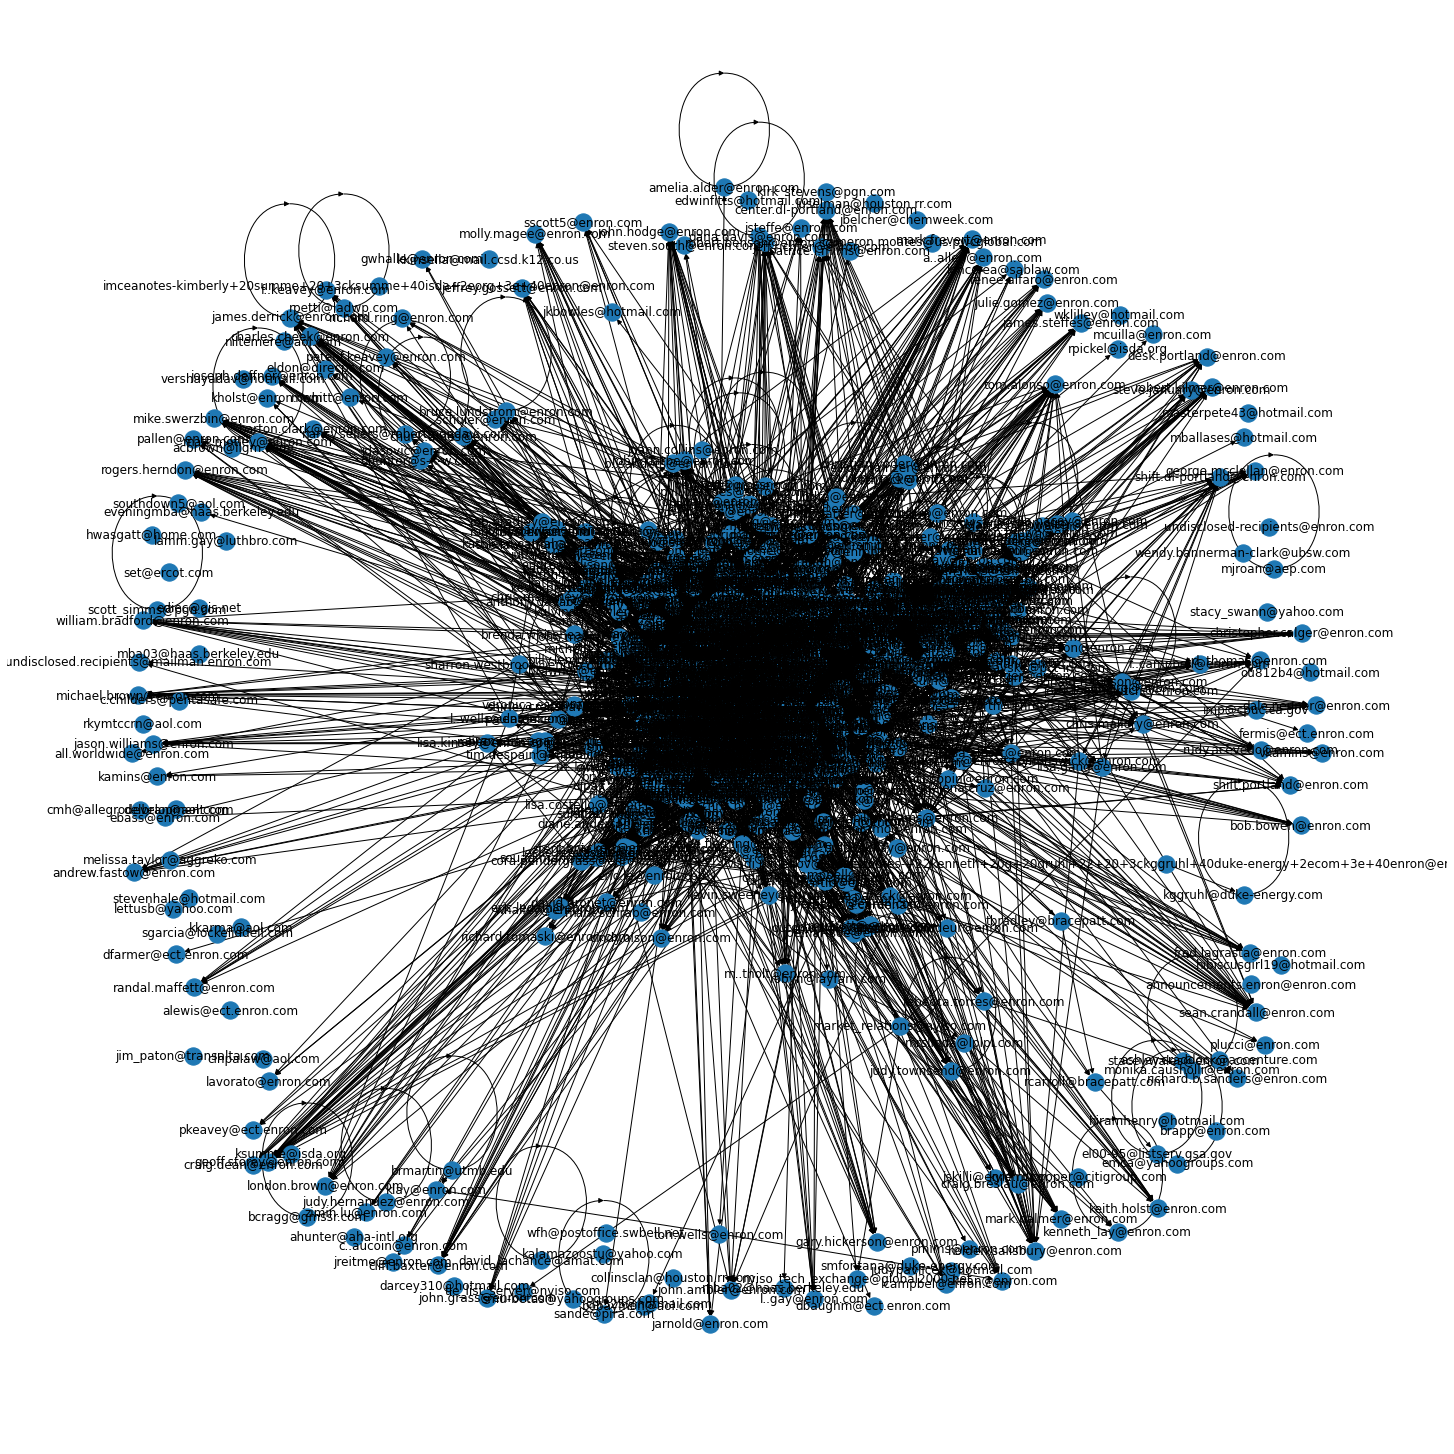

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize all of the enron network
l = [n for n, degree in dict(g.degree()).items() if degree > 10]
h = g.subgraph(l)
plt.figure(figsize=(20,20))
nx.draw_spring(h, with_labels=True)

##### Visualization of degree centraity

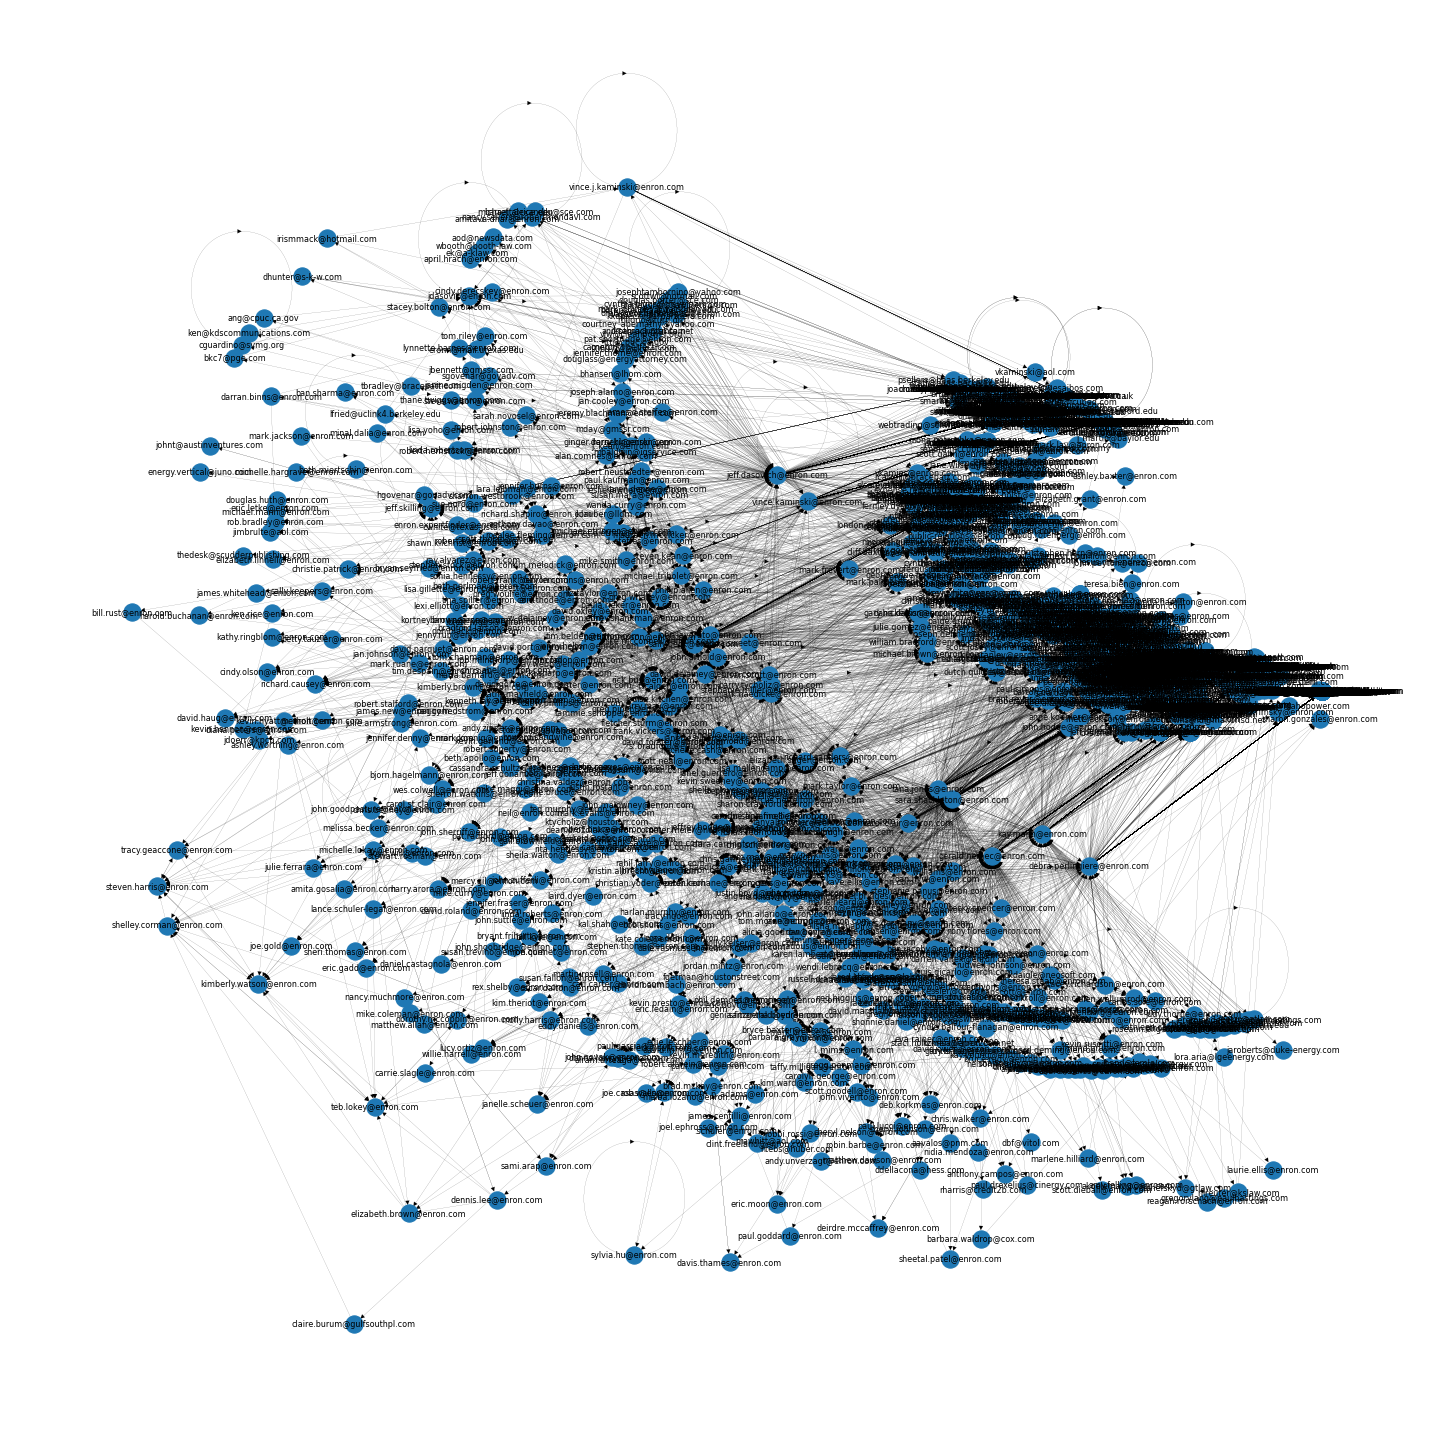

In [71]:
# visualize the degree centrality measure. I chose the top 10 degree centrality nodes and their neighbors.
neighbors = []
for node in d_results:
  neighbors.extend(list(g.neighbors(node)))
  
p = g.subgraph(d_results + neighbors)
plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(p, with_labels=True, width=.1, font_size=8)